In [1]:
from torchvision import datasets, transforms
from tqdm import tqdm
from torch import nn
import torch
import pandas as pd
from KAN import create_model_KAN, plot_convkan_splines, postactivations_KAN
from CNN import create_model_CNN, viz_kernels_aggregated_over_in, viz_rgb_first_layer, viz_kernels_per_in_channel, postactivations_CNN
from dataset import stratified_split, CustomImageDataset
from torch.utils.data import DataLoader

model=create_model_CNN()
df_merged = pd.read_pickle("/mnt/e/AI_stuff/Plant pathology explainability with KAN and CNN/Kan-for-Plant-Pathology/diamos.pkl")

In [3]:
root_dir = "/mnt/e/AI_stuff/Plant pathology explainability with KAN and CNN/Kan-for-Plant-Pathology"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

df_train, df_test = stratified_split(df_merged)


train_dataset = CustomImageDataset(df_train, root_dir=root_dir, transform=transform)
test_dataset = CustomImageDataset(df_test, root_dir=root_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)

In [ ]:
model.train()
torch.cuda.empty_cache()

pbar = tqdm(range(0,40))

for epoch in pbar:
    torch.cuda.empty_cache()
    
    for i, (x, y) in enumerate(train_loader):
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        pbar.set_description(f'Loss: {loss.item():.2e}')

model.eval()
correct = 0
total = 0

with torch.no_grad():
    pbar = tqdm(test_loader)
    for x, y in pbar:
        x, y = x.cuda(), y.cuda()
        y_hat = model(x)
        _, predicted = torch.max(y_hat, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
        pbar.set_description(f'Accuracy: {100 * correct / total:.2f}%')
    torch.cuda.empty_cache()


  0%|          | 0/40 [00:00<?, ?it/s]ERROR:tornado.general:SEND Error: Host unreachable


In [4]:
torch.save(model,"CIFAR10-39%-CNN.pt")

In [5]:
if isinstance(layer, ConvKAN) and hasattr(layer, "kan_layer"):
    postactivations_KAN(model,test_loader)

NameError: name 'layer' is not defined

In [ ]:

for i, layer in enumerate(model):
    if isinstance(layer, ConvKAN) and hasattr(layer, "kan_layer"):
        plot_convkan_splines(
            layer=layer,
            kernel_size=layer.kernel_size[0],       
            in_channels=layer.in_channels,
            out_channels=layer.out_channels,
            title_prefix=f"Layer {i}"
        )


NameError: name 'ConvKAN' is not defined

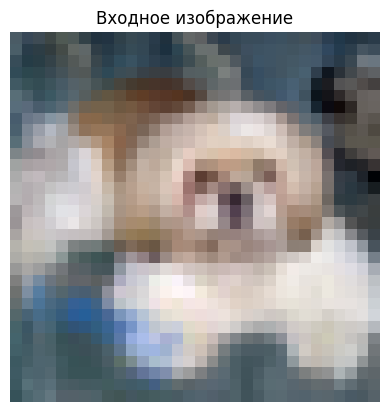

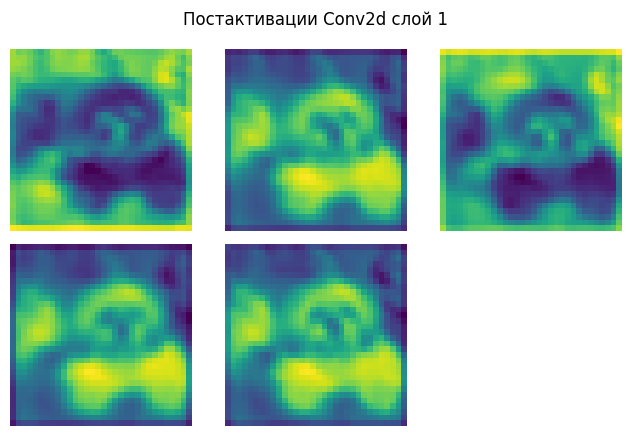

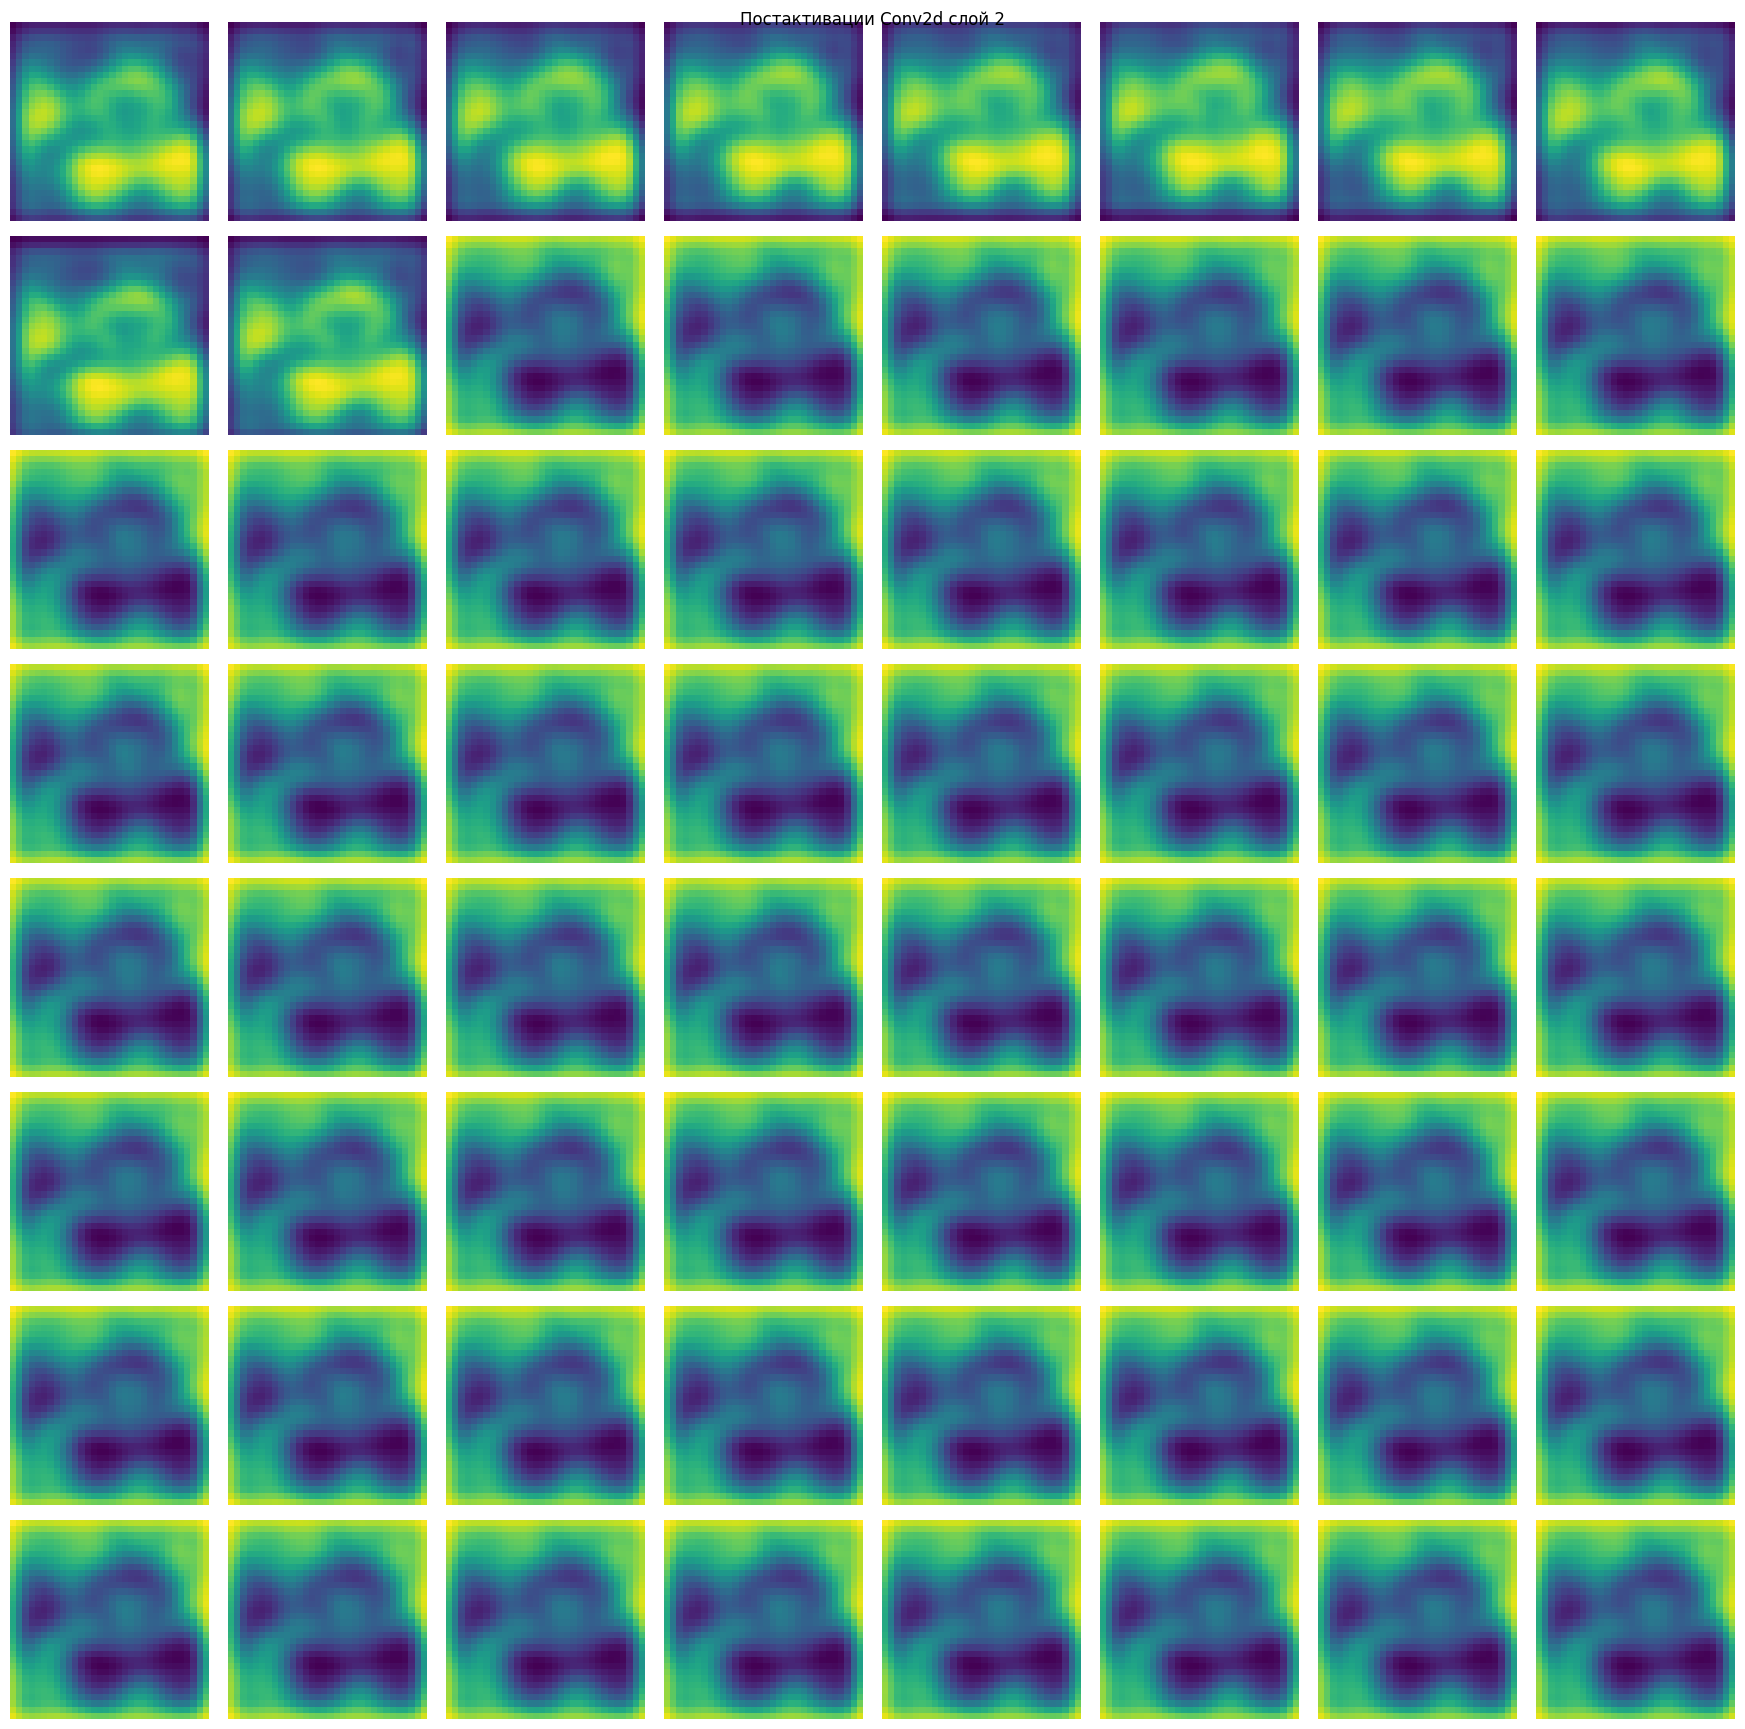

In [8]:
postactivations_CNN(model,test_loader)

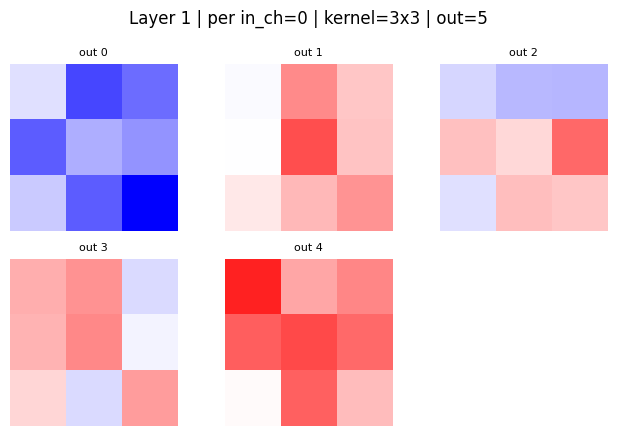

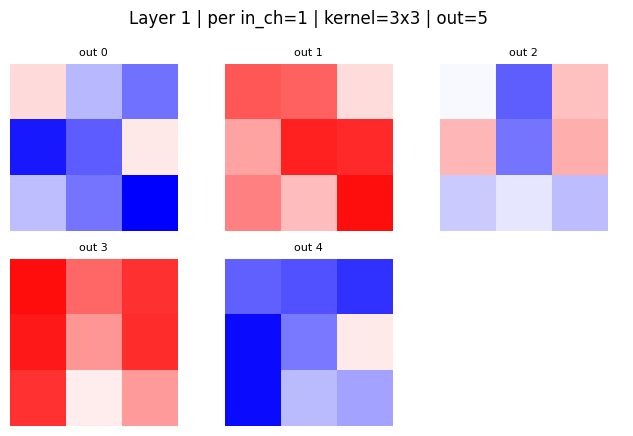

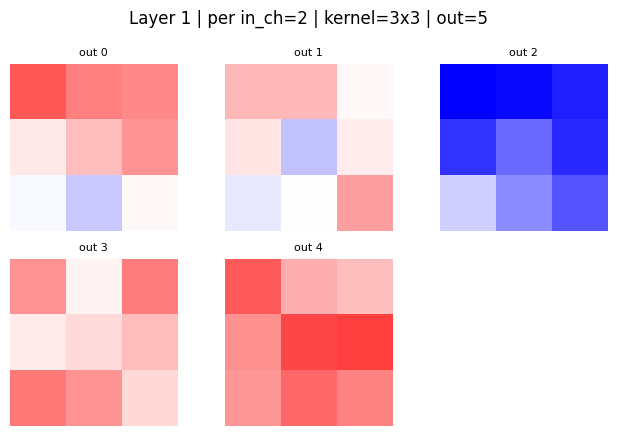

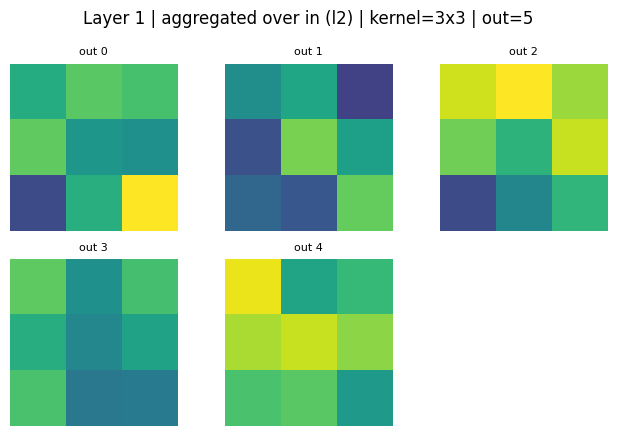

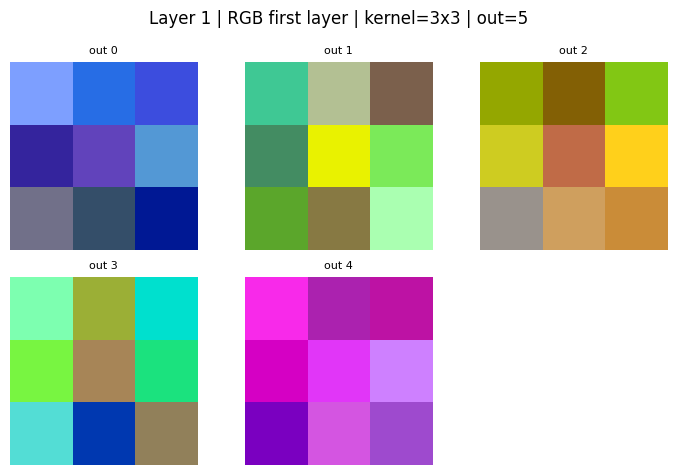

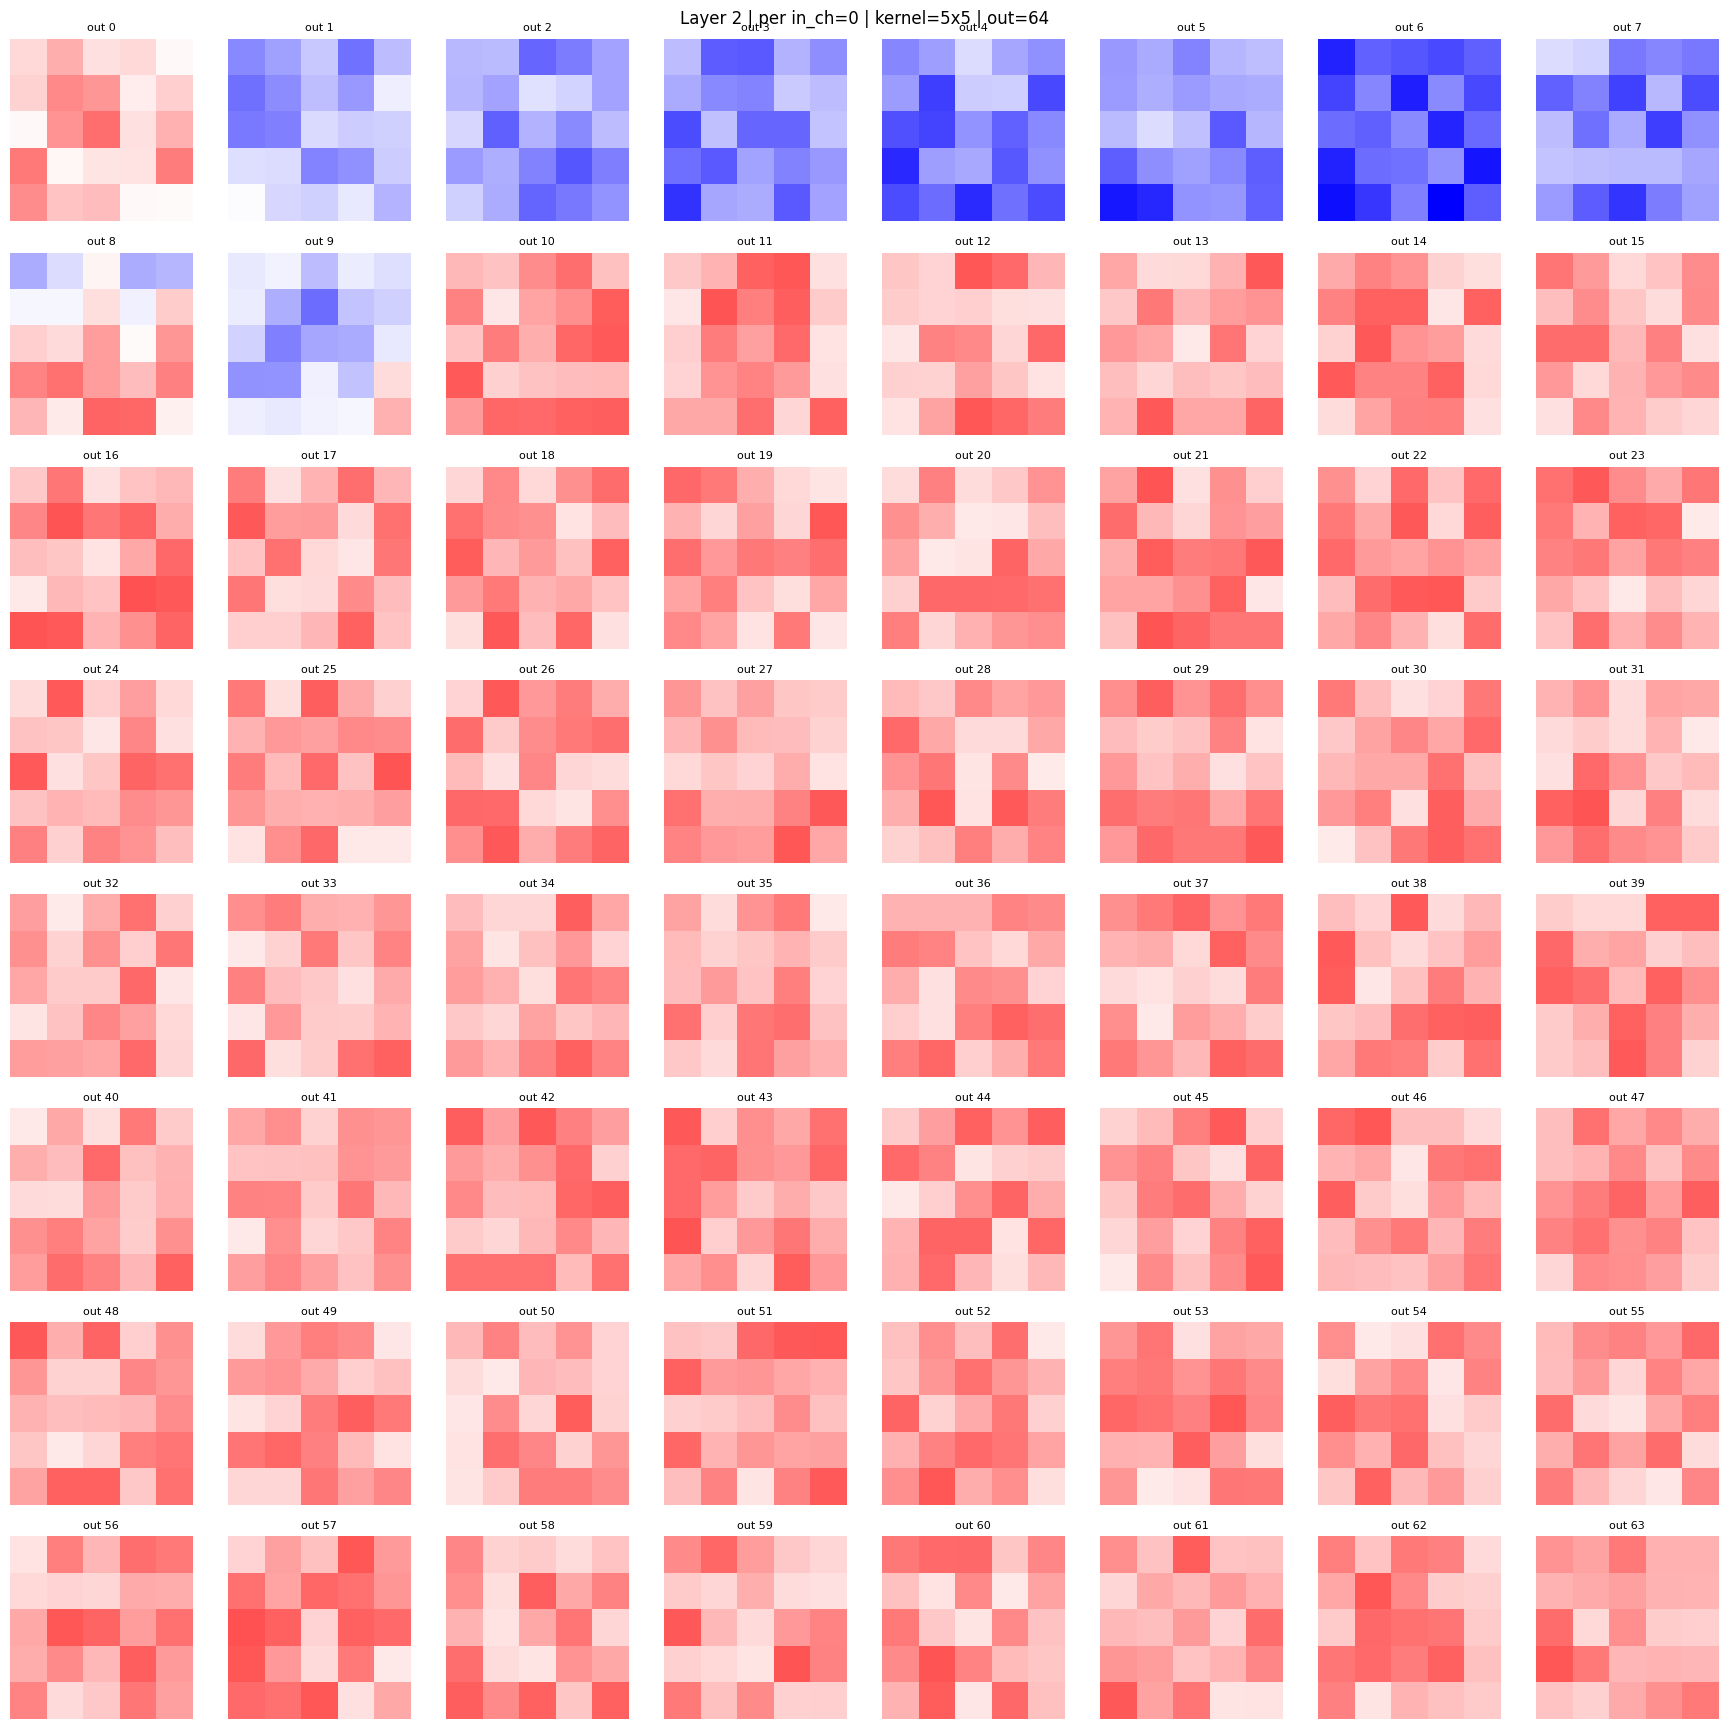

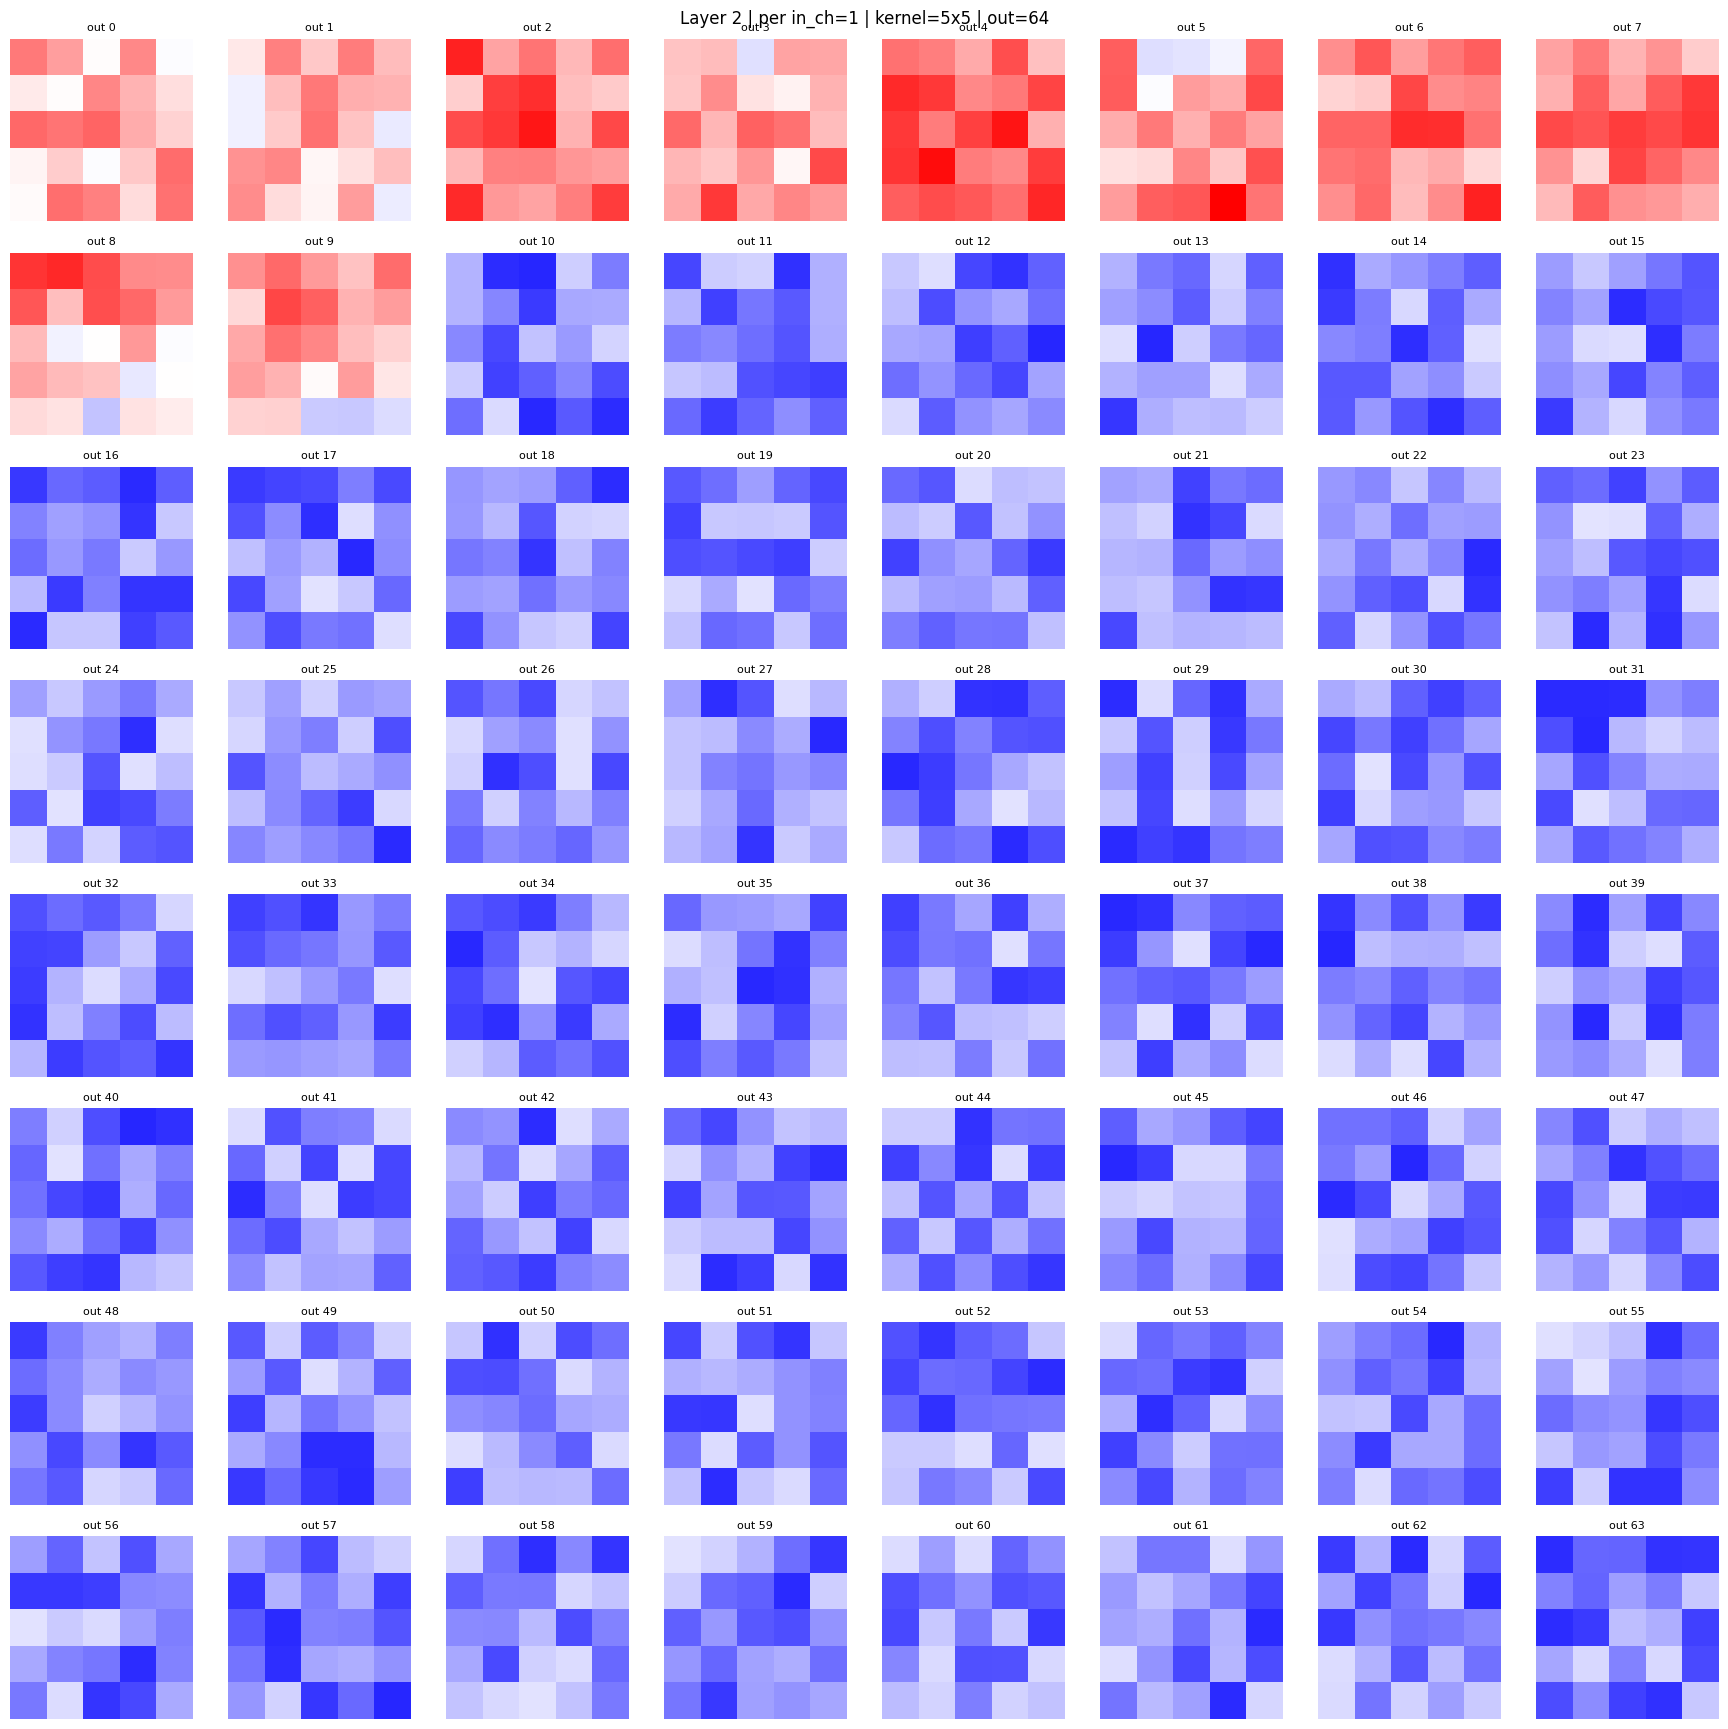

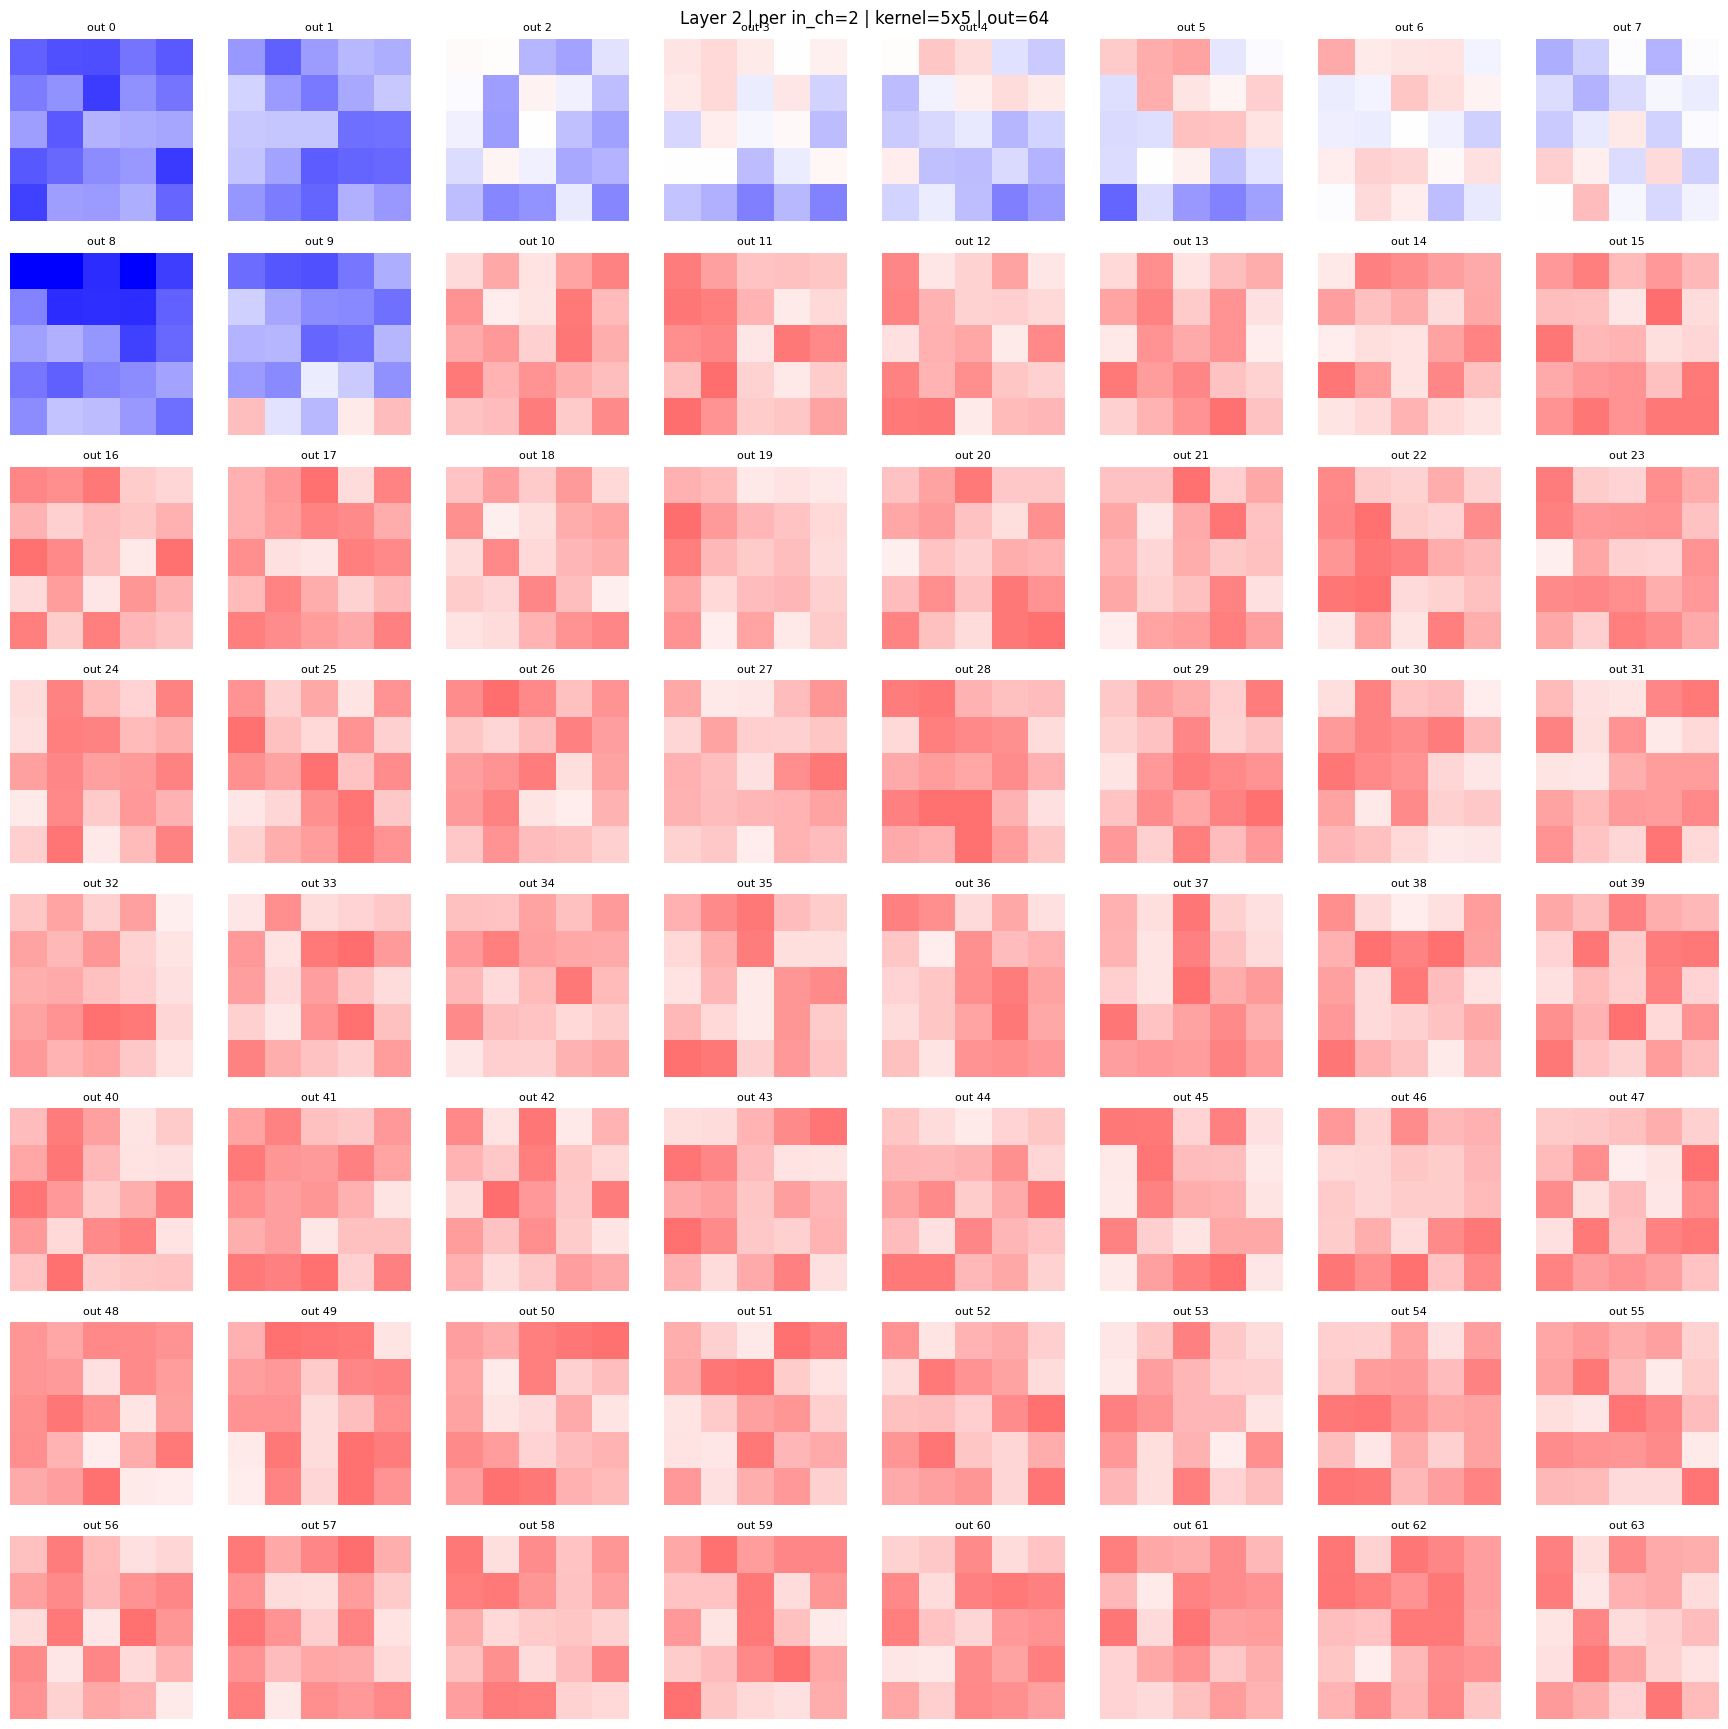

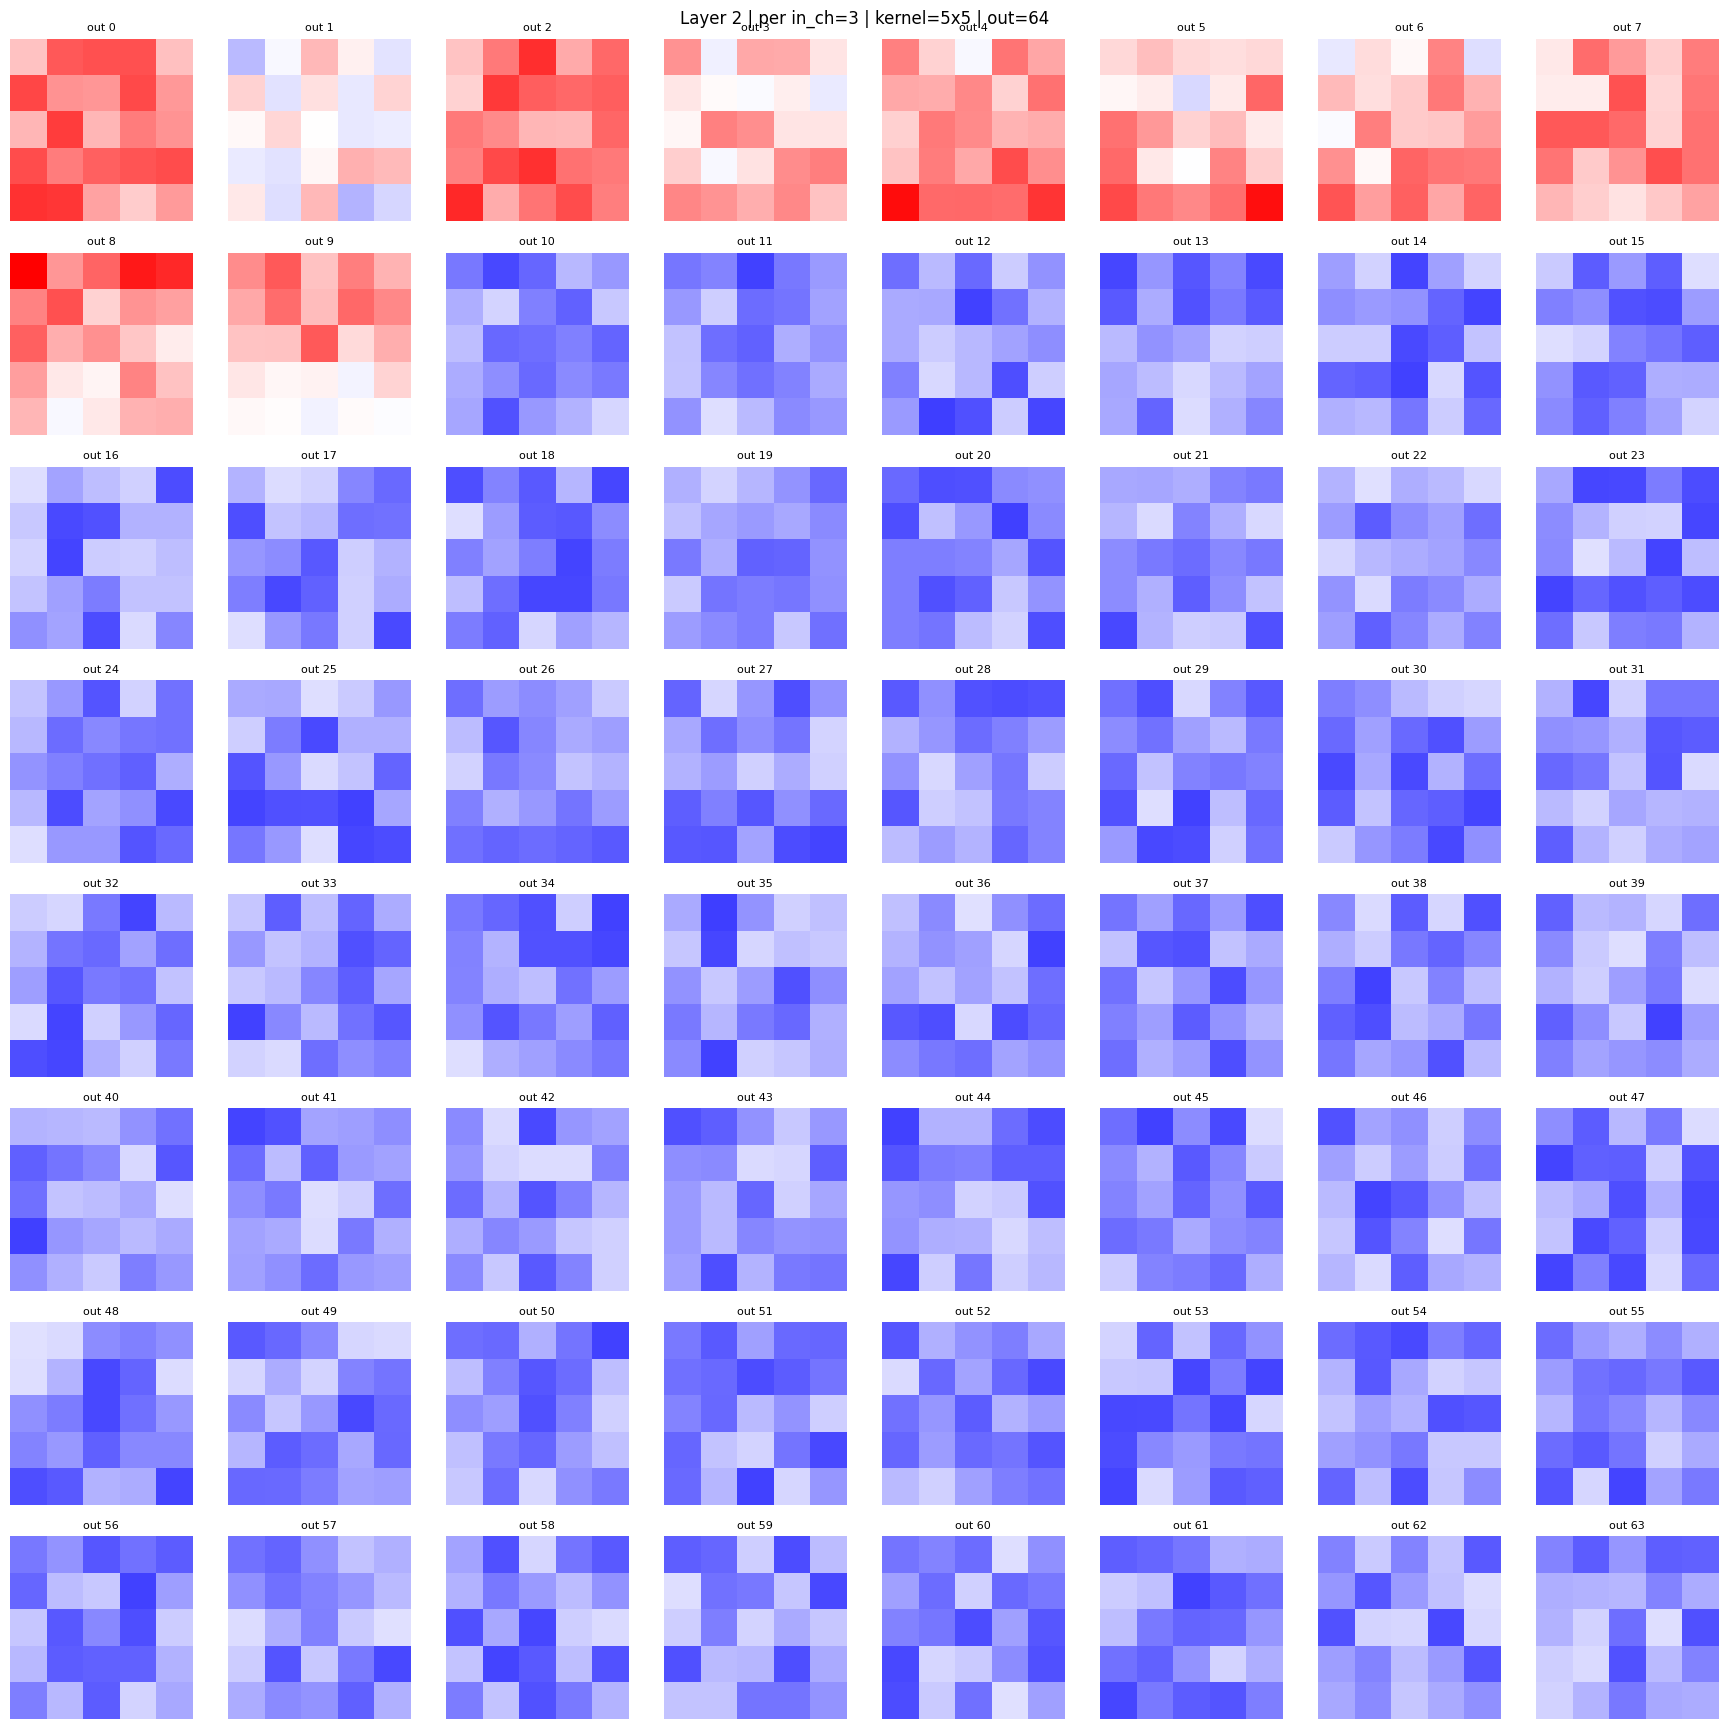

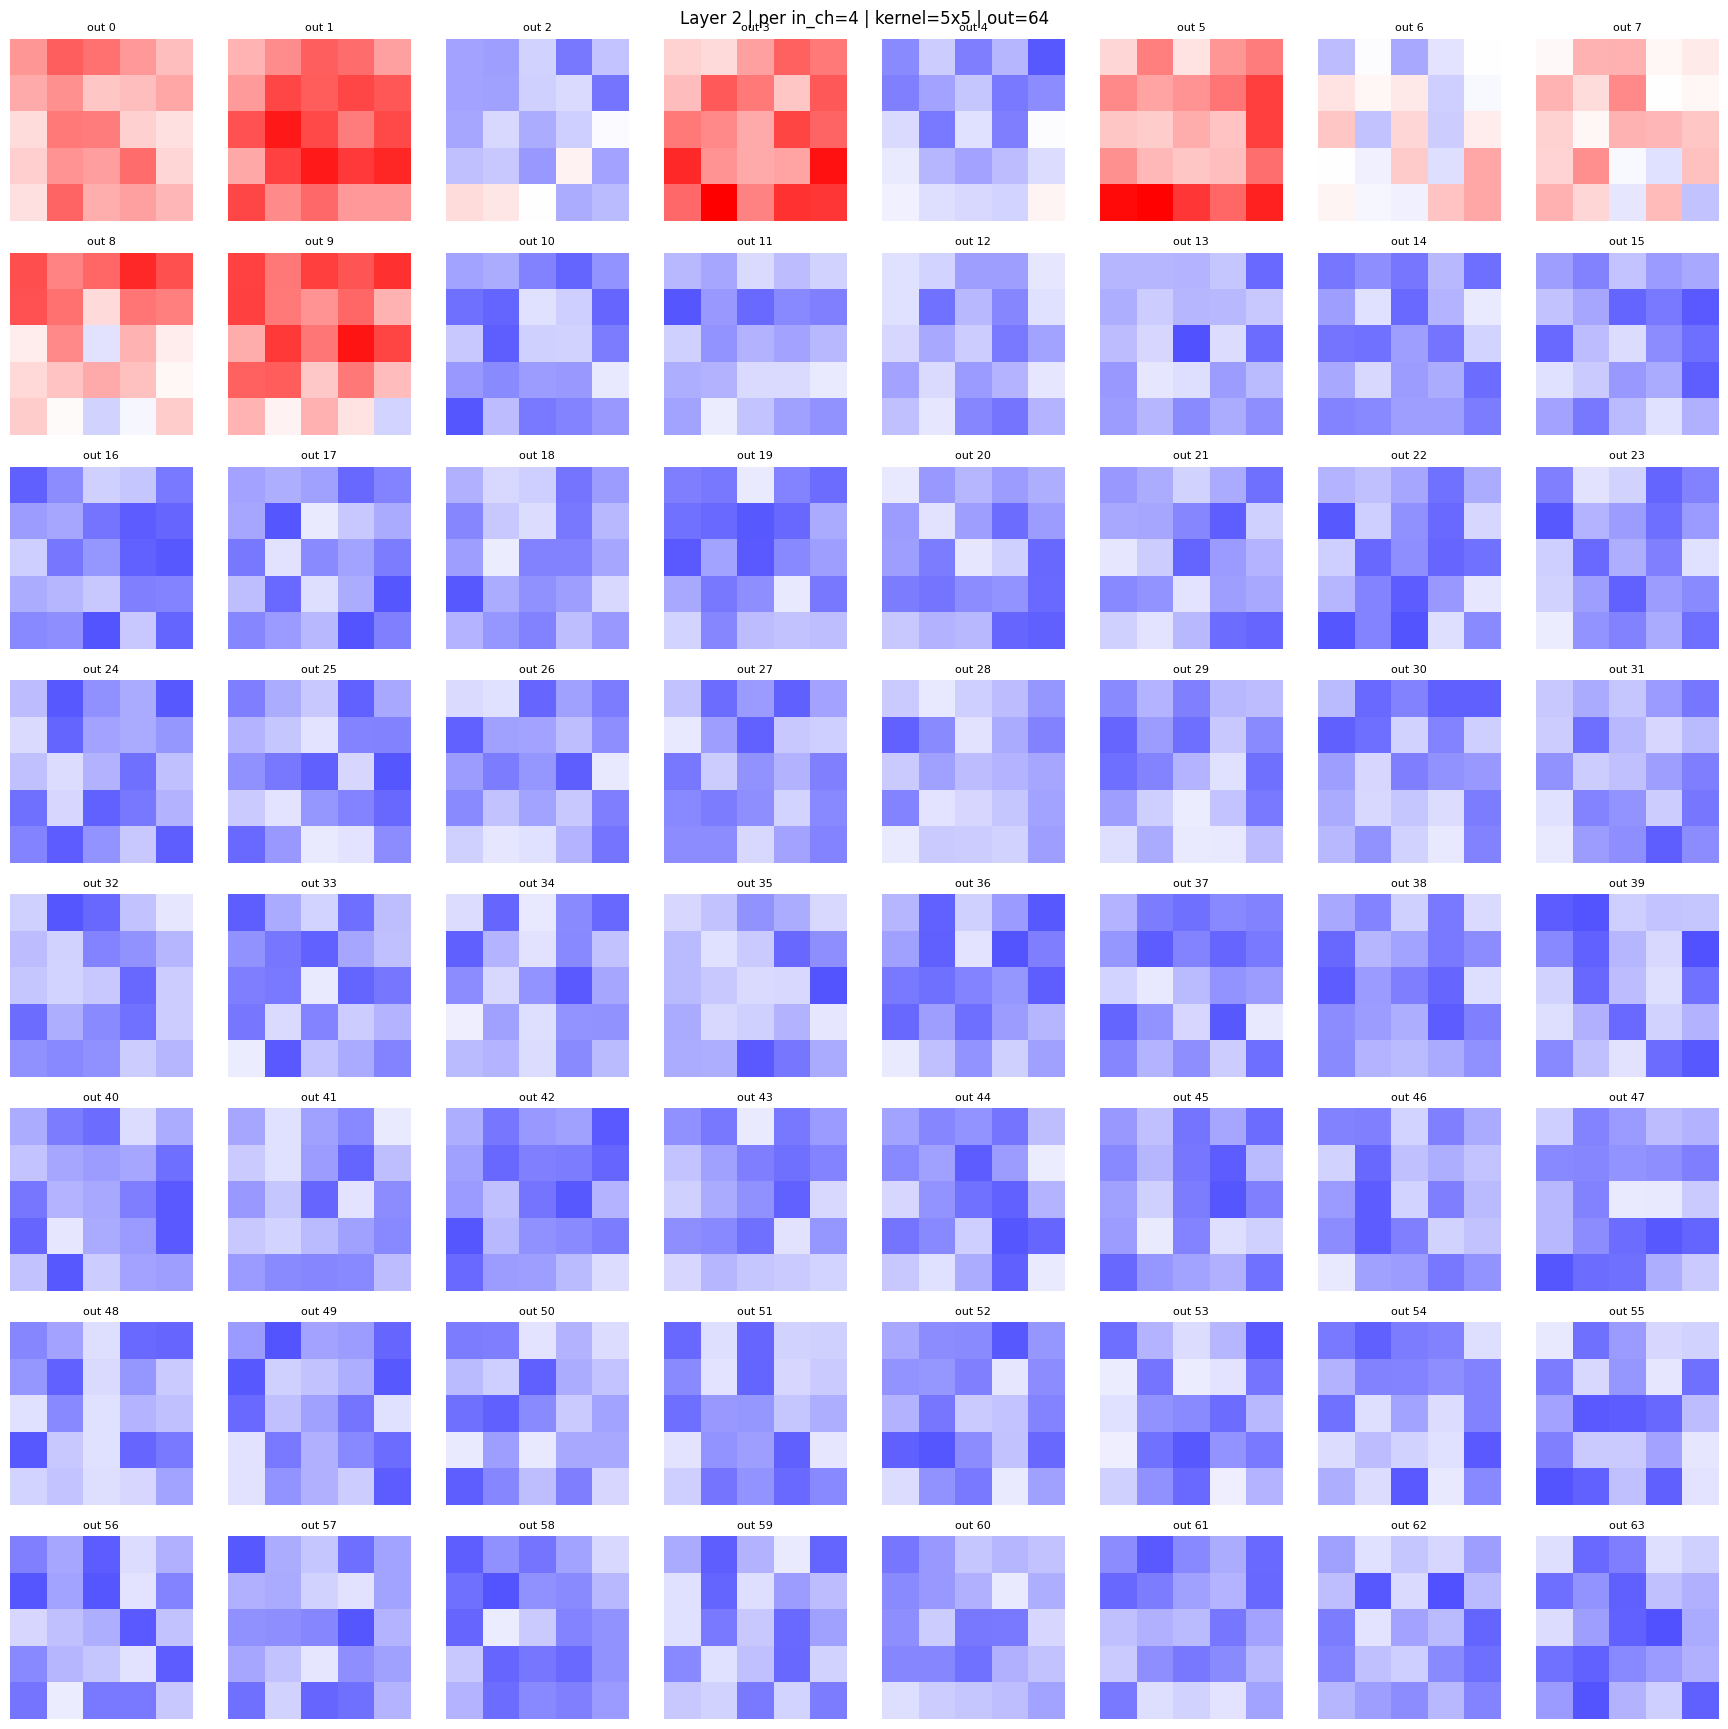

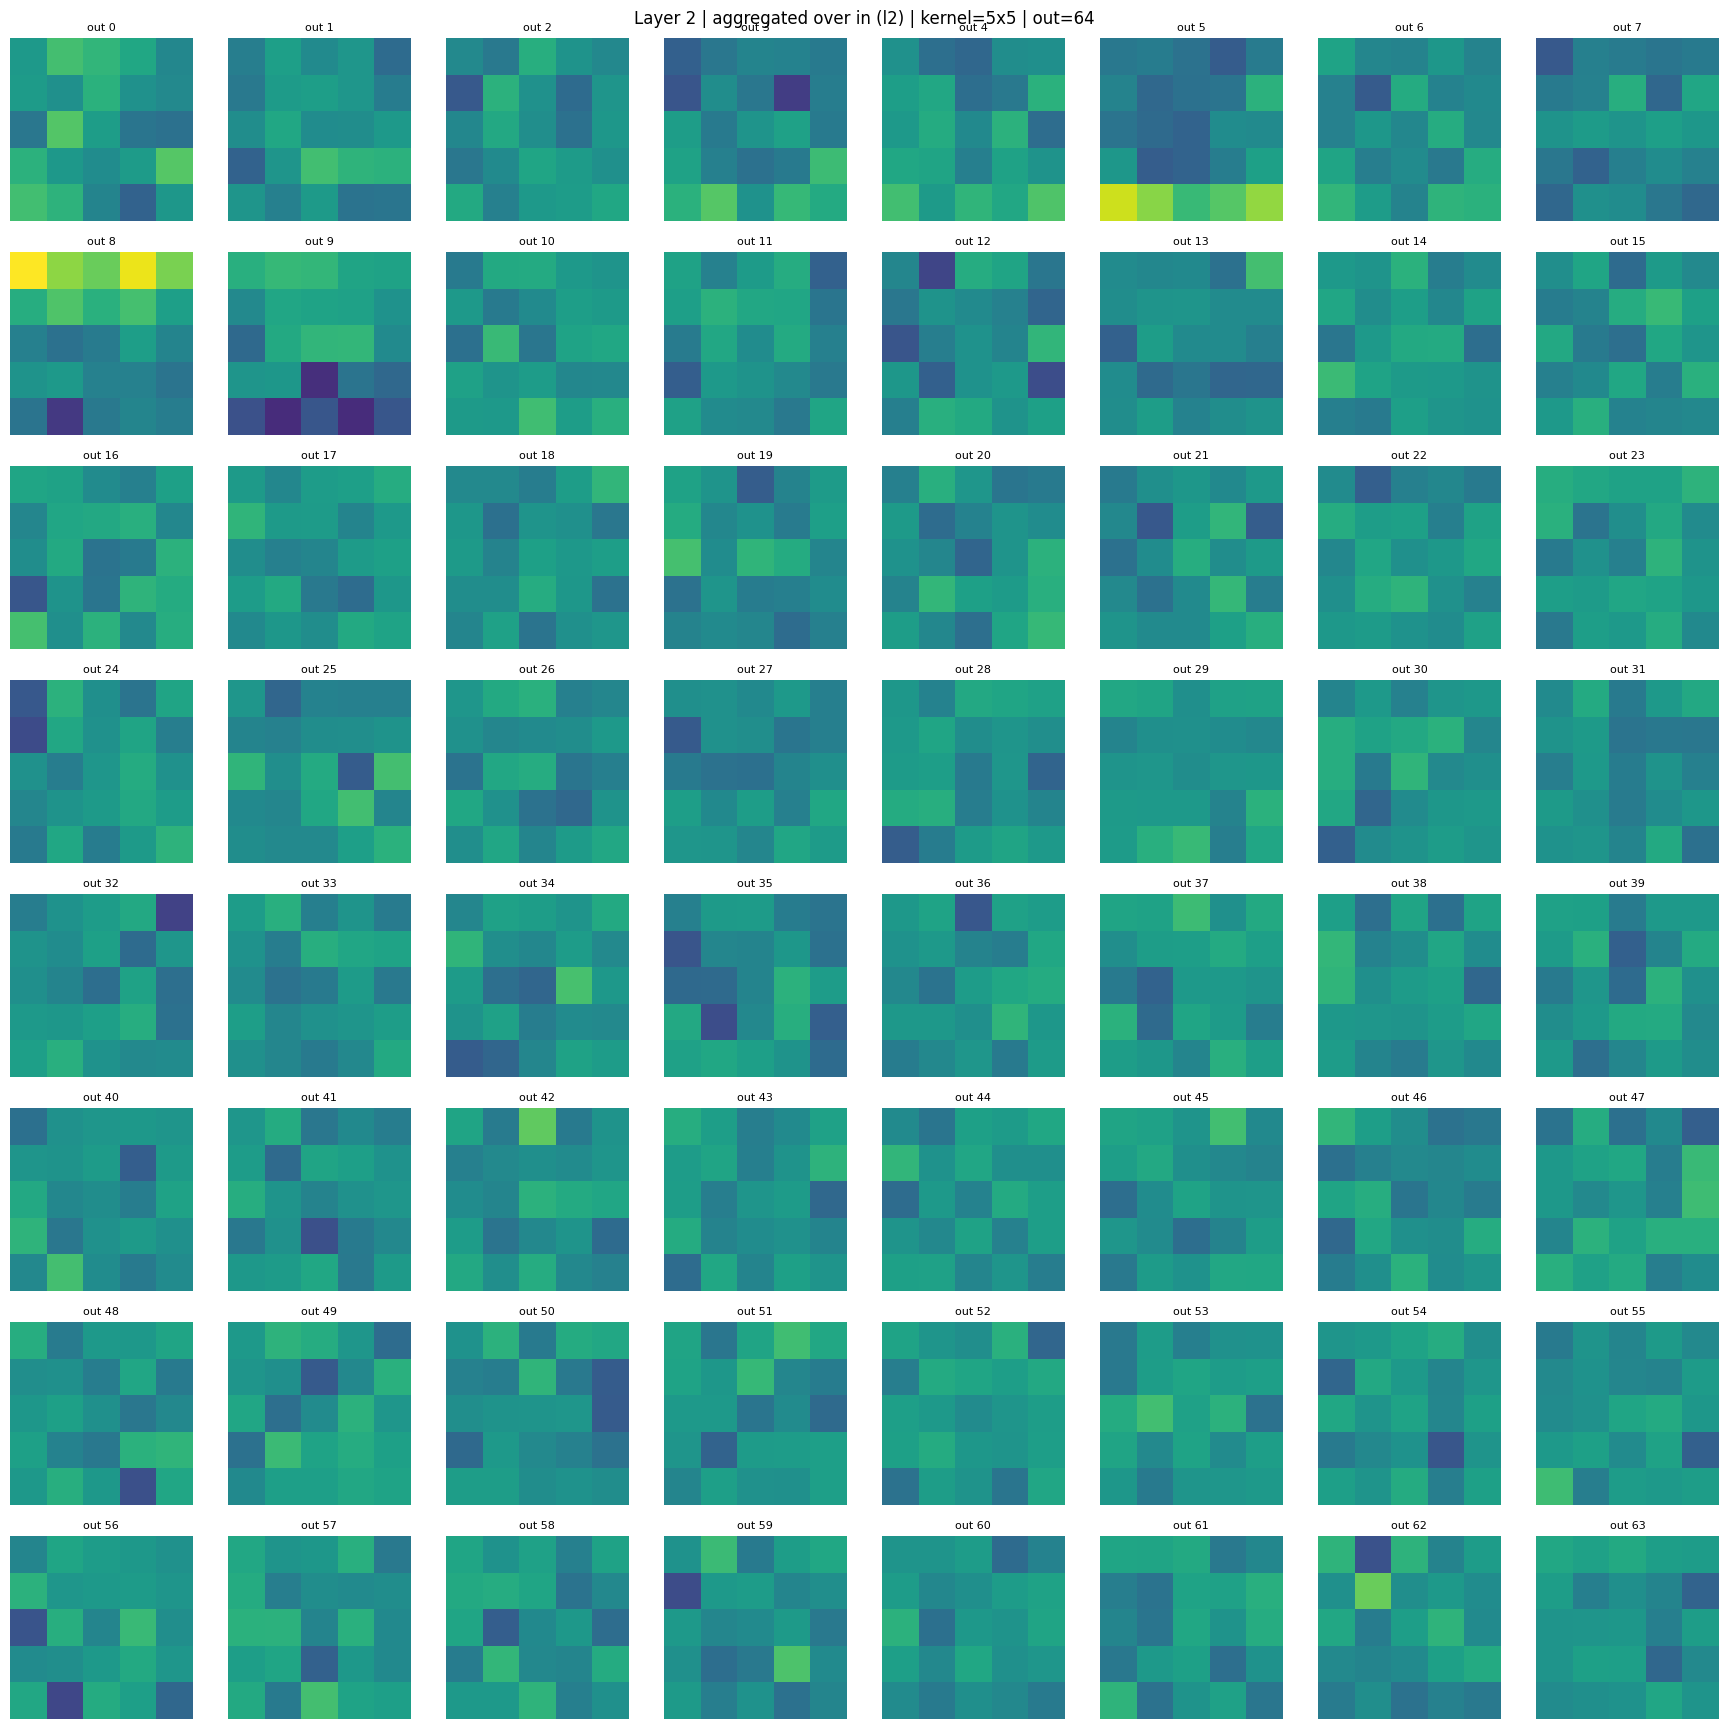

In [ ]:
for i, m in enumerate(model.modules()):
    if isinstance(m, nn.Conv2d):
        viz_kernels_per_in_channel(m, title_prefix=f"Layer {i}")

        viz_kernels_aggregated_over_in(m, reduce="l2", title_prefix=f"Layer {i}")

        try:
            viz_rgb_first_layer(m, title_prefix=f"Layer {i}", clip_mode="minmax")
        except ValueError:
            pass  
